In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import numpy as np
from adjustText import adjust_text
import requests
from io import BytesIO

COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

team_logos = pd.read_csv('https://raw.githubusercontent.com/guga31bb/nflfastR-data/master/teams_colors_logos.csv')
logos = pd.Series(team_logos.team_logo_wikipedia.values,index=team_logos.team_abbr).to_dict()
pd.set_option('display.max_colwidth', 1000)

In [2]:
#Single season
YEAR = 2020

data = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(YEAR) + '.csv.gz?raw=True',compression='gzip', low_memory=False
    )

In [3]:
df = data[
        (data.play_type.isin(['pass','run', 'no_play'])) &
        (data.two_point_attempt==0) &
        (data['epa'].isna()==False) & 
        (data['week'] < 18)
        ]

# Team stats:

In [4]:
off_data = (
    df.groupby(['posteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()

off_data.columns = ['team', 'off_epa', 'off_plays']

def_data = (
    df.groupby(['defteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()

def_data['epa'] = -def_data['epa']

def_data.columns = ['team', 'def_epa', 'def_plays']

epa_data = pd.merge(off_data, def_data, left_on='team', right_on='team')

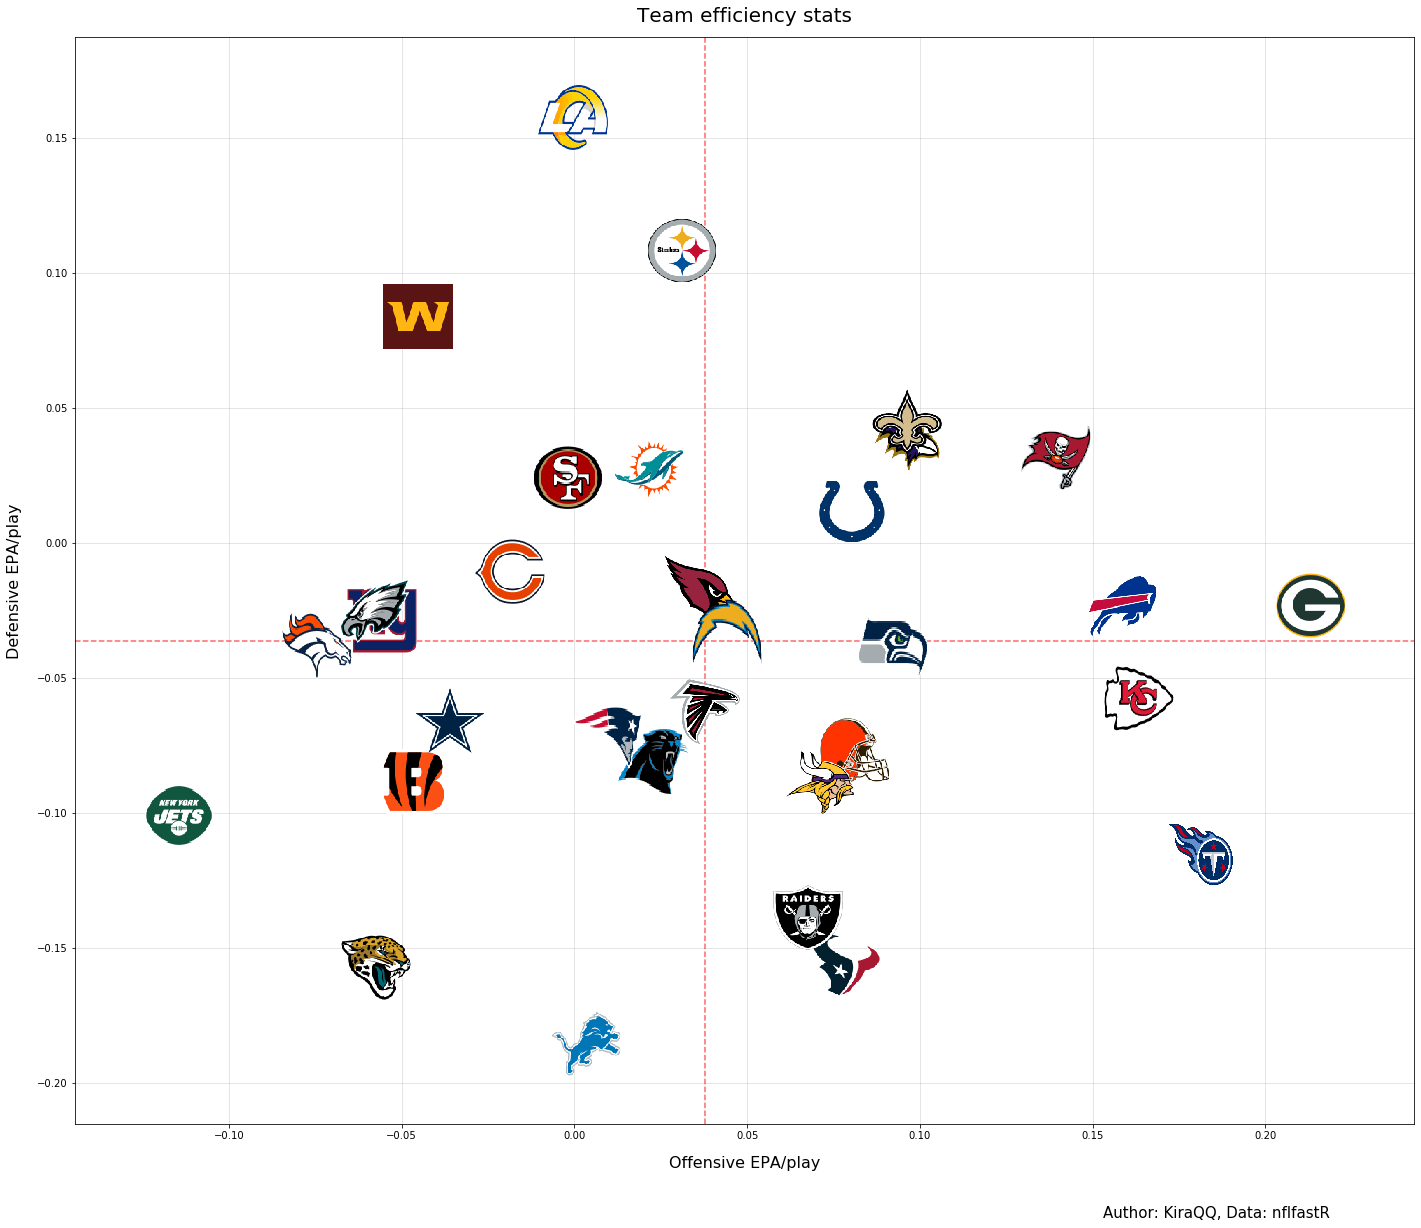

In [5]:
fig, ax = plt.subplots(figsize=(24,20))
x = epa_data['off_epa'].values
y = epa_data['def_epa'].values

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)
ax.set_ylim(y.min() - 0.03, y.max() + 0.03)
ax.set_xlim(x.min() - 0.03, x.max() + 0.03)
off_avg = x.mean()
def_avg = y.mean()

# annotate the points with team logos
for idx, row in epa_data.iterrows():
  logo_src = team_logos[team_logos['team_abbr'] == str(epa_data['team'][idx])]['team_logo_wikipedia'].values[0]
  res = requests.get(logo_src)
  img = plt.imread(BytesIO(res.content))
  ax.imshow(img, extent=[row['off_epa']-0.01, row['off_epa']+0.01, row['def_epa']-0.012, row['def_epa']+0.012], aspect='auto', zorder=1000)

#Add league average line
ax.axhline(y=def_avg,linestyle='--',color='red', alpha=.6)
ax.axvline(x=off_avg,linestyle='--',color='red', alpha=.6)
    
#Add title, labels, and cite the data source
ax.set_title('Team efficiency stats',fontsize=20,pad=15)
ax.set_xlabel('Offensive EPA/play',fontsize=16,labelpad=15)
ax.set_ylabel('Defensive EPA/play',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [6]:
rush_epa = df.loc[(df.play_type == 'run')]

pass_epa = df.loc[(df.play_type == 'pass')]

off_rush_epa = (
    rush_epa.groupby(['posteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()
off_rush_epa.columns = ['team', 'off_rush_epa', 'off_rush_plays']

def_rush_epa = (
    rush_epa.groupby(['defteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()
def_rush_epa.columns = ['team', 'def_rush_epa', 'def_rush_plays']
def_rush_epa['def_rush_epa'] = -def_rush_epa['def_rush_epa']

off_pass_epa = (
    pass_epa.groupby(['posteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()
off_pass_epa.columns = ['team', 'off_pass_epa', 'off_pass_plays']

def_pass_epa = (
    pass_epa.groupby(['defteam']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()
def_pass_epa.columns = ['team', 'def_pass_epa', 'def_pass_plays']
def_pass_epa['def_pass_epa'] = -def_pass_epa['def_pass_epa']

off_data = pd.merge(off_rush_epa, off_pass_epa, left_on='team', right_on='team')
def_data = pd.merge(def_rush_epa, def_pass_epa, left_on='team', right_on='team')

off_data['path'] = off_data['team'].map(logos)
def_data['path'] = def_data['team'].map(logos)

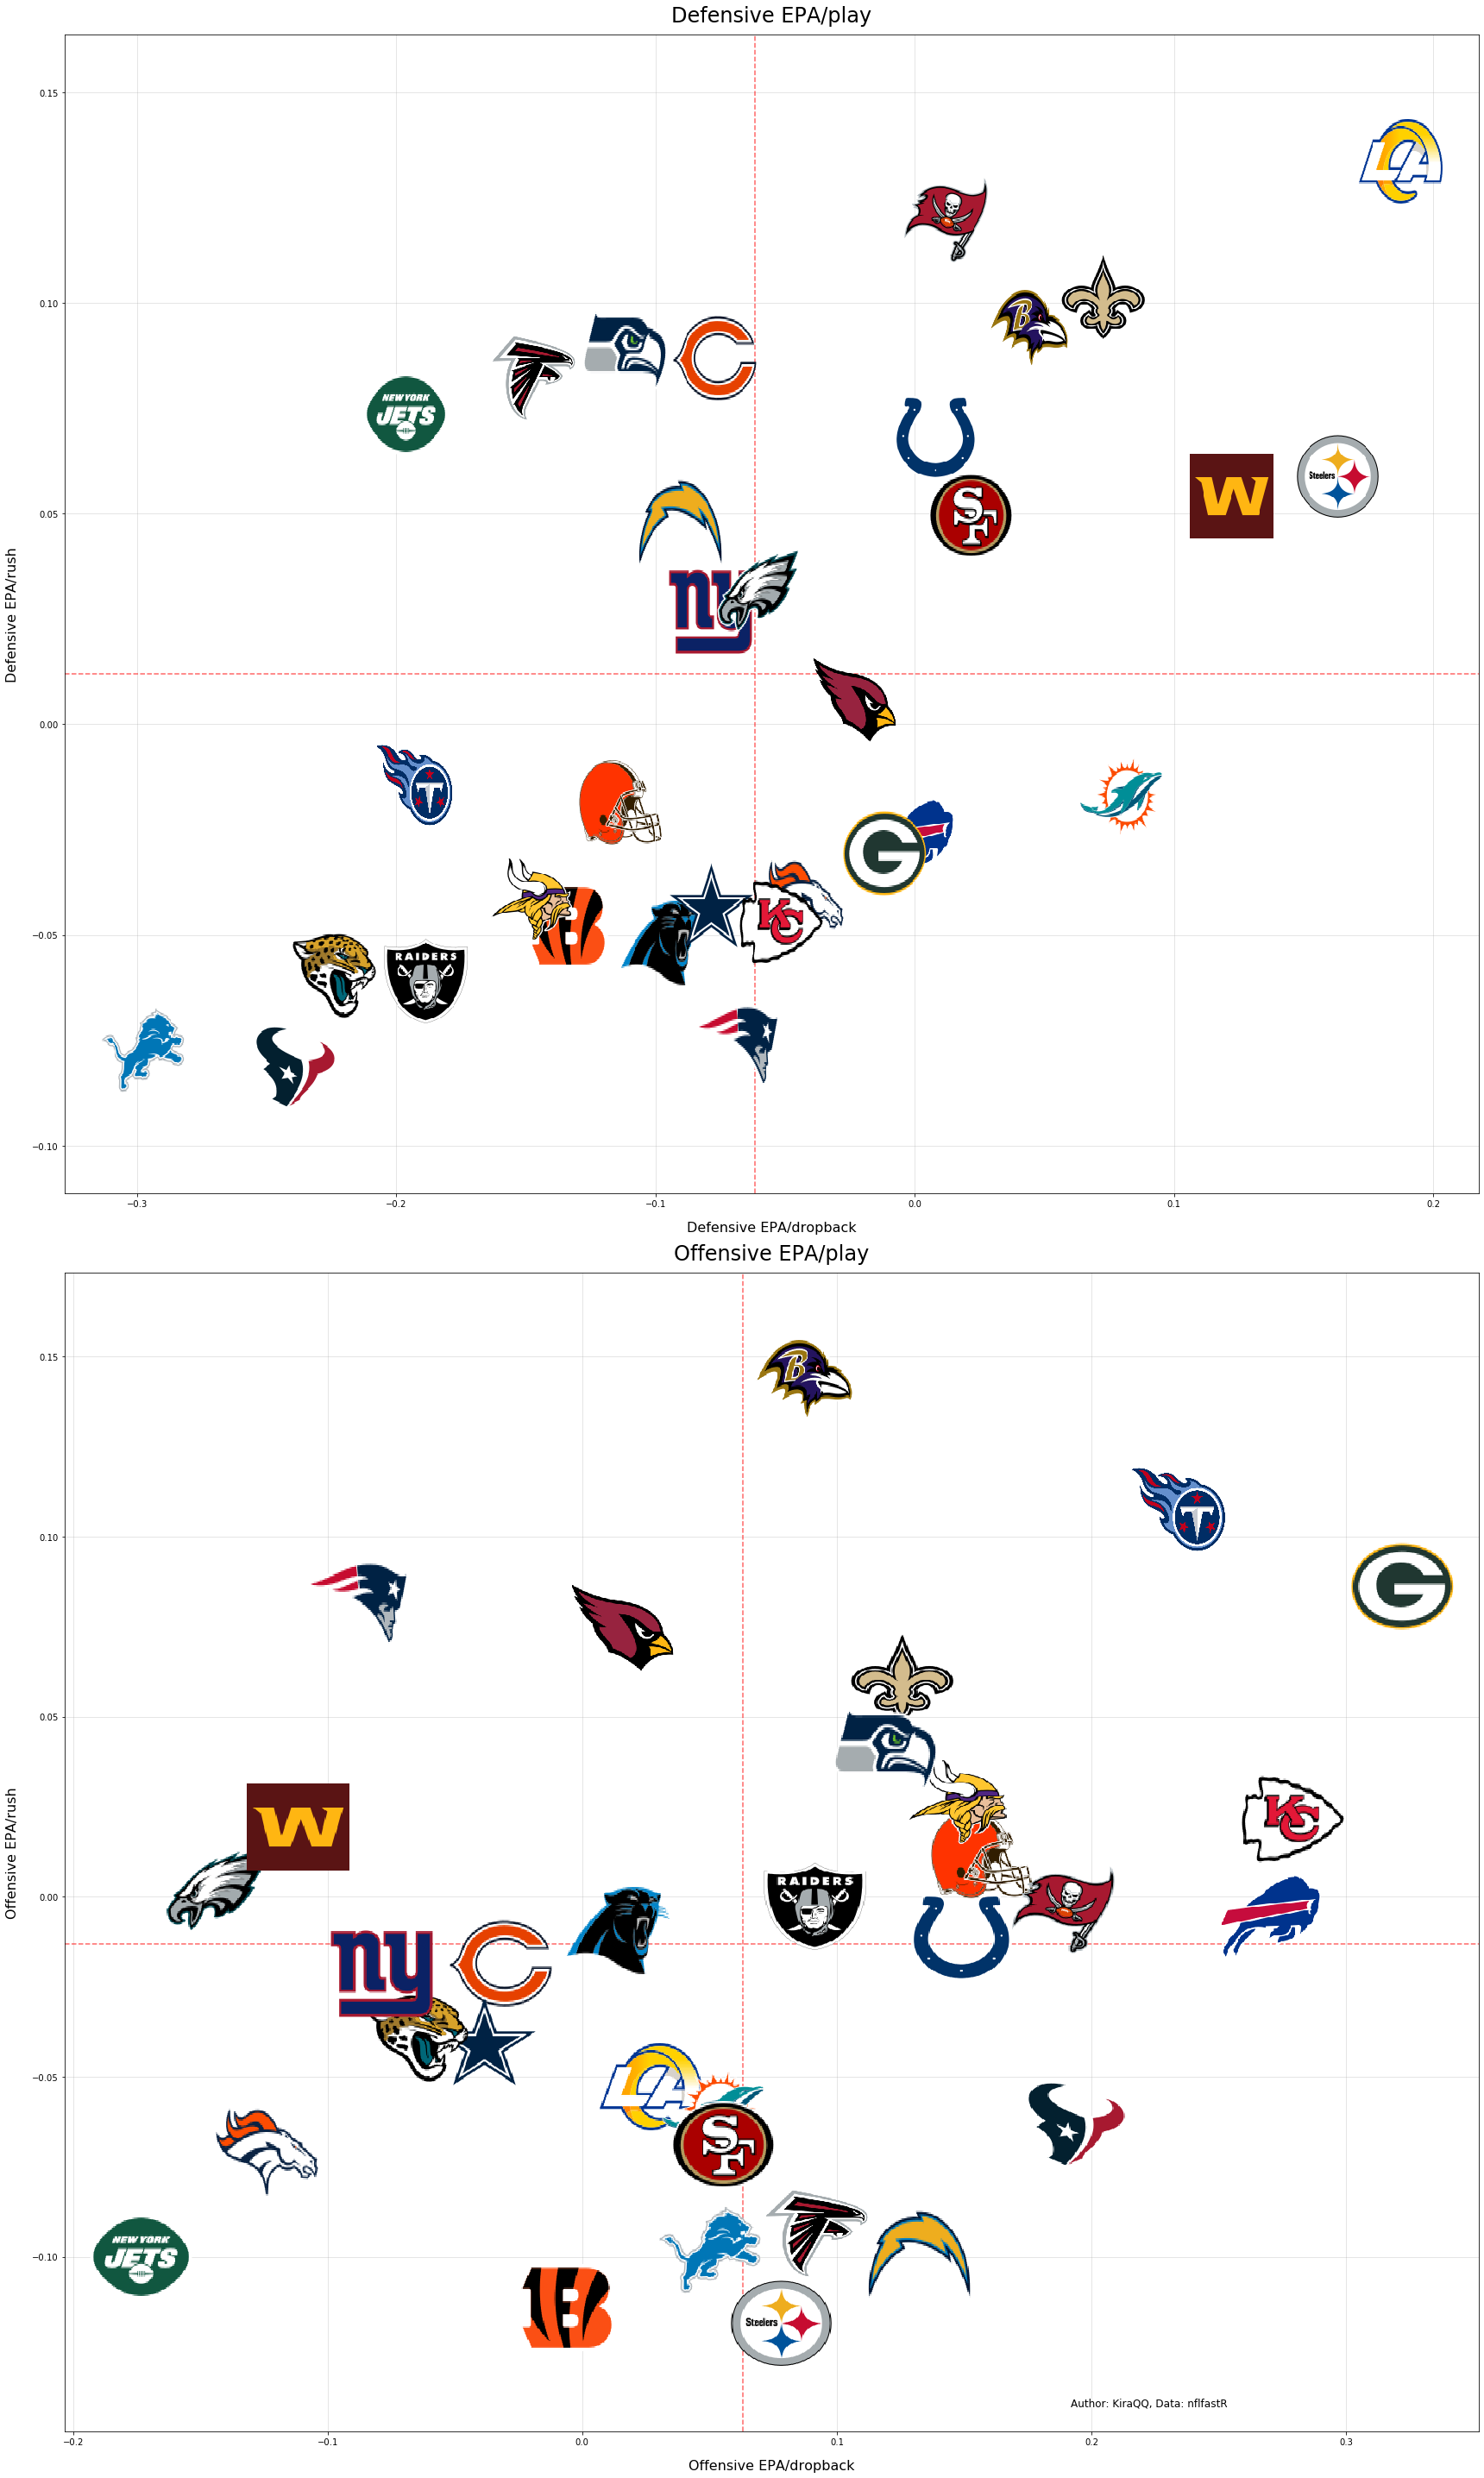

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 40))

#Add grids
axes[0].grid(zorder=0,alpha=.4)
axes[1].grid(zorder=0,alpha=.4)
axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[0].set_ylim(def_data['def_rush_epa'].min() - 0.03, def_data['def_rush_epa'].max() + 0.03)
axes[0].set_xlim(def_data['def_pass_epa'].min() - 0.03, def_data['def_pass_epa'].max() + 0.03)
axes[1].set_ylim(off_data['off_rush_epa'].min() - 0.03, off_data['off_rush_epa'].max() + 0.03)
axes[1].set_xlim(off_data['off_pass_epa'].min() - 0.03, off_data['off_pass_epa'].max() + 0.03)

# annotate the points with team logos
for idx, row in def_data.iterrows():
  logo_src = str(row['path'])
  res = requests.get(logo_src)
  img = plt.imread(BytesIO(res.content))
  axes[0].imshow(img, extent=[row['def_pass_epa']-0.016, row['def_pass_epa']+0.016, row['def_rush_epa']-0.01, row['def_rush_epa']+0.01], aspect='auto', zorder=1000)

for idx, row in off_data.iterrows():
  logo_src = str(row['path'])
  res = requests.get(logo_src)
  img = plt.imread(BytesIO(res.content))
  axes[1].imshow(img, extent=[row['off_pass_epa']-0.02, row['off_pass_epa']+0.02, row['off_rush_epa']-0.012, row['off_rush_epa']+0.012], aspect='auto', zorder=1000)

#Add league average line
axes[0].axhline(y=def_data['def_rush_epa'].mean(),linestyle='--',color='red', alpha=.6)
axes[0].axvline(x=def_data['def_pass_epa'].mean(),linestyle='--',color='red', alpha=.6)
axes[1].axhline(y=off_data['off_rush_epa'].mean(),linestyle='--',color='red', alpha=.6)
axes[1].axvline(x=off_data['off_pass_epa'].mean(),linestyle='--',color='red', alpha=.6)

#Add title, labels, and cite the data source
axes[0].set_title('Defensive EPA/play',fontsize=24,pad=15)
axes[1].set_title('Offensive EPA/play',fontsize=24,pad=15)
axes[0].set_xlabel('Defensive EPA/dropback',fontsize=16,labelpad=15)
axes[0].set_ylabel('Defensive EPA/rush',fontsize=16,labelpad=15)
axes[1].set_xlabel('Offensive EPA/dropback',fontsize=16,labelpad=15)
axes[1].set_ylabel('Offensive EPA/rush',fontsize=16,labelpad=15)
plt.figtext(.72,.03,'Author: KiraQQ, Data: nflfastR',fontsize=12);
fig.tight_layout()

In [8]:
df_early = df[
    (df.down > 0) & (df.down < 3)
].copy()

early_data = (
    df_early.groupby(['posteam']).agg({'success': 'mean', 'wpa': 'count'})
).reset_index()

early_data.sort_values('success', ascending=False, inplace=True)
early_data['success'] = early_data['success']*100
early_data['color'] = early_data['posteam'].map(COLORS)
early_data['path'] = early_data['posteam'].map(logos)
early_data.reset_index(inplace=True)

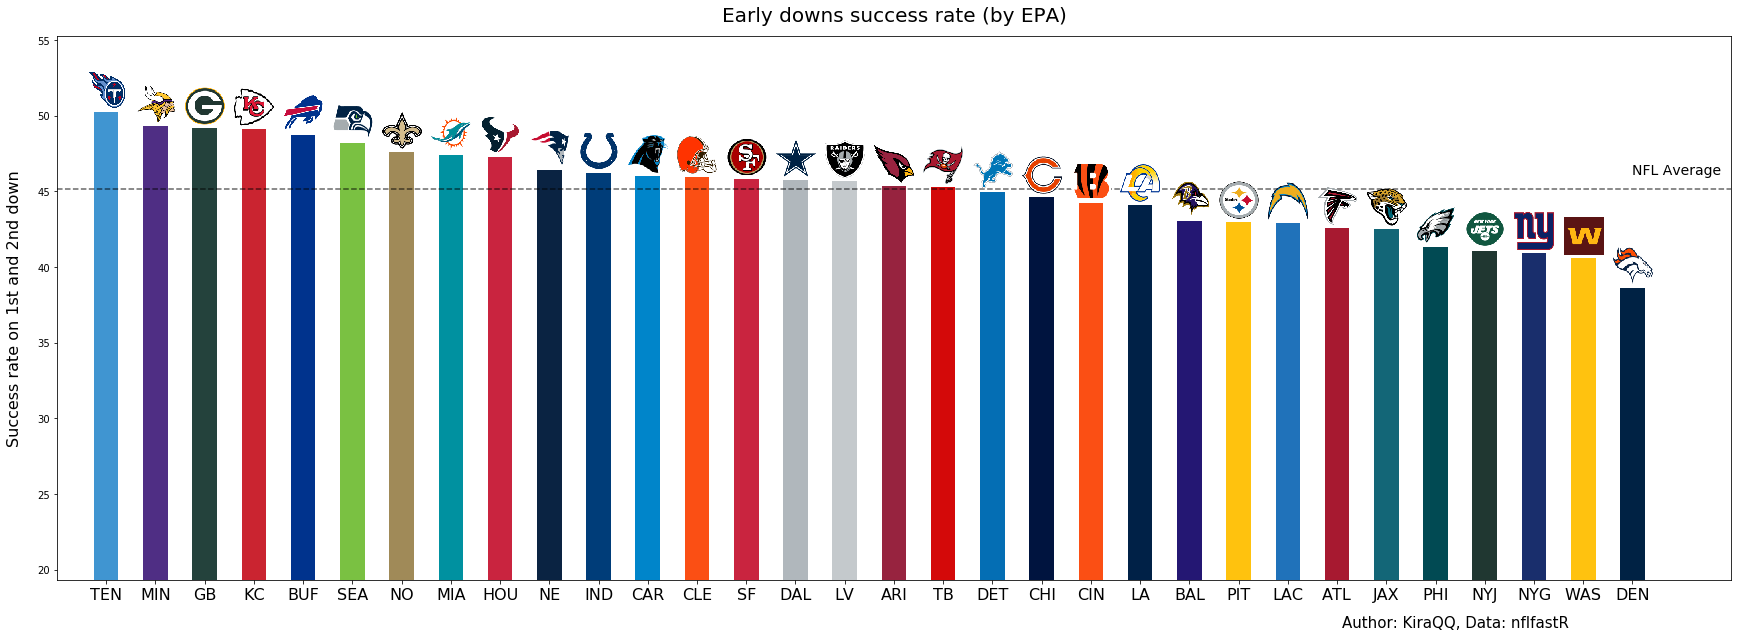

In [9]:
fig, ax = plt.subplots(figsize=(30,10))

ax.bar(np.arange(0,32), early_data['success'], color=early_data.color, width=.5)
ax.set_ylim(early_data['success'].min()/2, early_data['success'].max() + 5)
ax.set_xlim(-1, 33)

for idx, row in early_data.iterrows():
    logo_src = str(row['path'])
    res = requests.get(logo_src)
    img = plt.imread(BytesIO(res.content))
    ax.imshow(img, extent=[idx-0.4, idx+0.4, row['success'] + 0.2, row['success']+ 2.7], aspect='auto', zorder=1000)
    
#Add title, labels, and cite the data source
ax.set_title('Early downs success rate (by EPA)',fontsize=20,pad=15)
ax.set_ylabel('Success rate on 1st and 2nd down',fontsize=16,labelpad=15)
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(early_data.posteam,fontsize=16)

#Add league average line and label
ax.axhline(y=early_data['success'].mean(),linestyle='--',color='black', alpha=.6)
plt.text(31, early_data['success'].mean() + 1, 'NFL Average',fontsize=14)

plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [10]:
df_early = df_early.loc[(df_early.wp > 0.2) & (df_early.wp < 0.8) & (df_early.half_seconds_remaining > 120) & (df_early.ydstogo < 15) & (df_early.ydstogo > 1)]

early_pass = (
    df_early.groupby(['posteam']).agg({'qb_dropback': 'mean', 'wpa': 'count'})
).reset_index()

early_pass['qb_dropback'] = early_pass['qb_dropback']*100
pass_avg = early_pass['qb_dropback'].mean()

early_pass.sort_values('qb_dropback', ascending=False, inplace=True)
early_pass['color'] = early_pass['posteam'].map(COLORS)
early_pass['path'] = early_pass['posteam'].map(logos)
early_pass.reset_index(inplace=True)

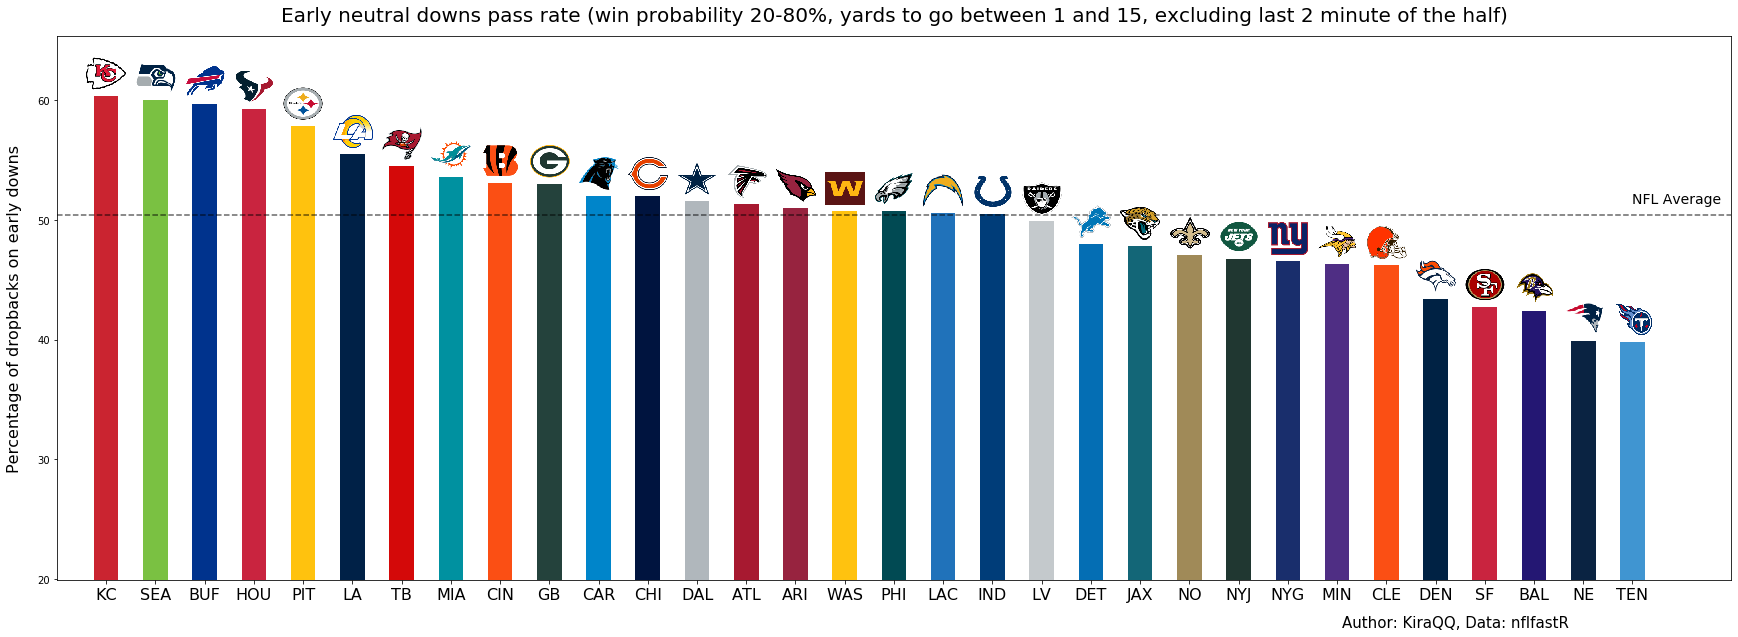

In [11]:
fig, ax = plt.subplots(figsize=(30,10))

ax.bar(np.arange(0,32), early_pass['qb_dropback'], color=early_pass.color, width=.5)
ax.set_ylim(early_pass['qb_dropback'].min()/2, early_pass['qb_dropback'].max() + 5)
ax.set_xlim(-1, 33)

for idx, row in early_pass.iterrows():
    logo_src = str(row['path'])
    res = requests.get(logo_src)
    img = plt.imread(BytesIO(res.content))
    ax.imshow(img, extent=[idx-0.4, idx+0.4, row['qb_dropback']+0.5, row['qb_dropback']+3.2], aspect='auto', zorder=1000)
    
#Add title, labels, and cite the data source
ax.set_title('Early neutral downs pass rate (win probability 20-80%, yards to go between 1 and 15, excluding last 2 minute of the half)',fontsize=20,pad=15)
ax.set_ylabel('Percentage of dropbacks on early downs',fontsize=16,labelpad=15)
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(early_pass.posteam,fontsize=16)

#Add league average line and label
ax.axhline(y=pass_avg,linestyle='--',color='black', alpha=.6)
plt.text(31, pass_avg + 1, 'NFL Average',fontsize=14)

plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [12]:
df_early_pass = df[
    (df.down > 0) & (df.down < 3) & (df.play_type == 'pass')
].copy()

df_early_rush = df[
    (df.down > 0) & (df.down < 3) & (df.play_type == 'run')
].copy()

pass_SR = (
    df_early_pass.groupby(['posteam']).agg({'success': 'mean', 'wpa': 'count'})
).reset_index()
pass_SR.columns = ['team', 'pass_success_rate', 'pass_plays']

rush_SR = (
    df_early_rush.groupby(['posteam']).agg({'success': 'mean', 'wpa': 'count'})
).reset_index()
rush_SR.columns = ['team', 'rush_success_rate', 'rush_plays']

SR_data = pd.merge(pass_SR, rush_SR, left_on='team', right_on='team')
SR_data['diff'] = SR_data['pass_success_rate'] - SR_data['rush_success_rate']
SR_data.sort_values('diff', ascending=False, inplace=True)
SR_data['color'] = SR_data['team'].map(COLORS)
SR_data.reset_index(inplace=True)

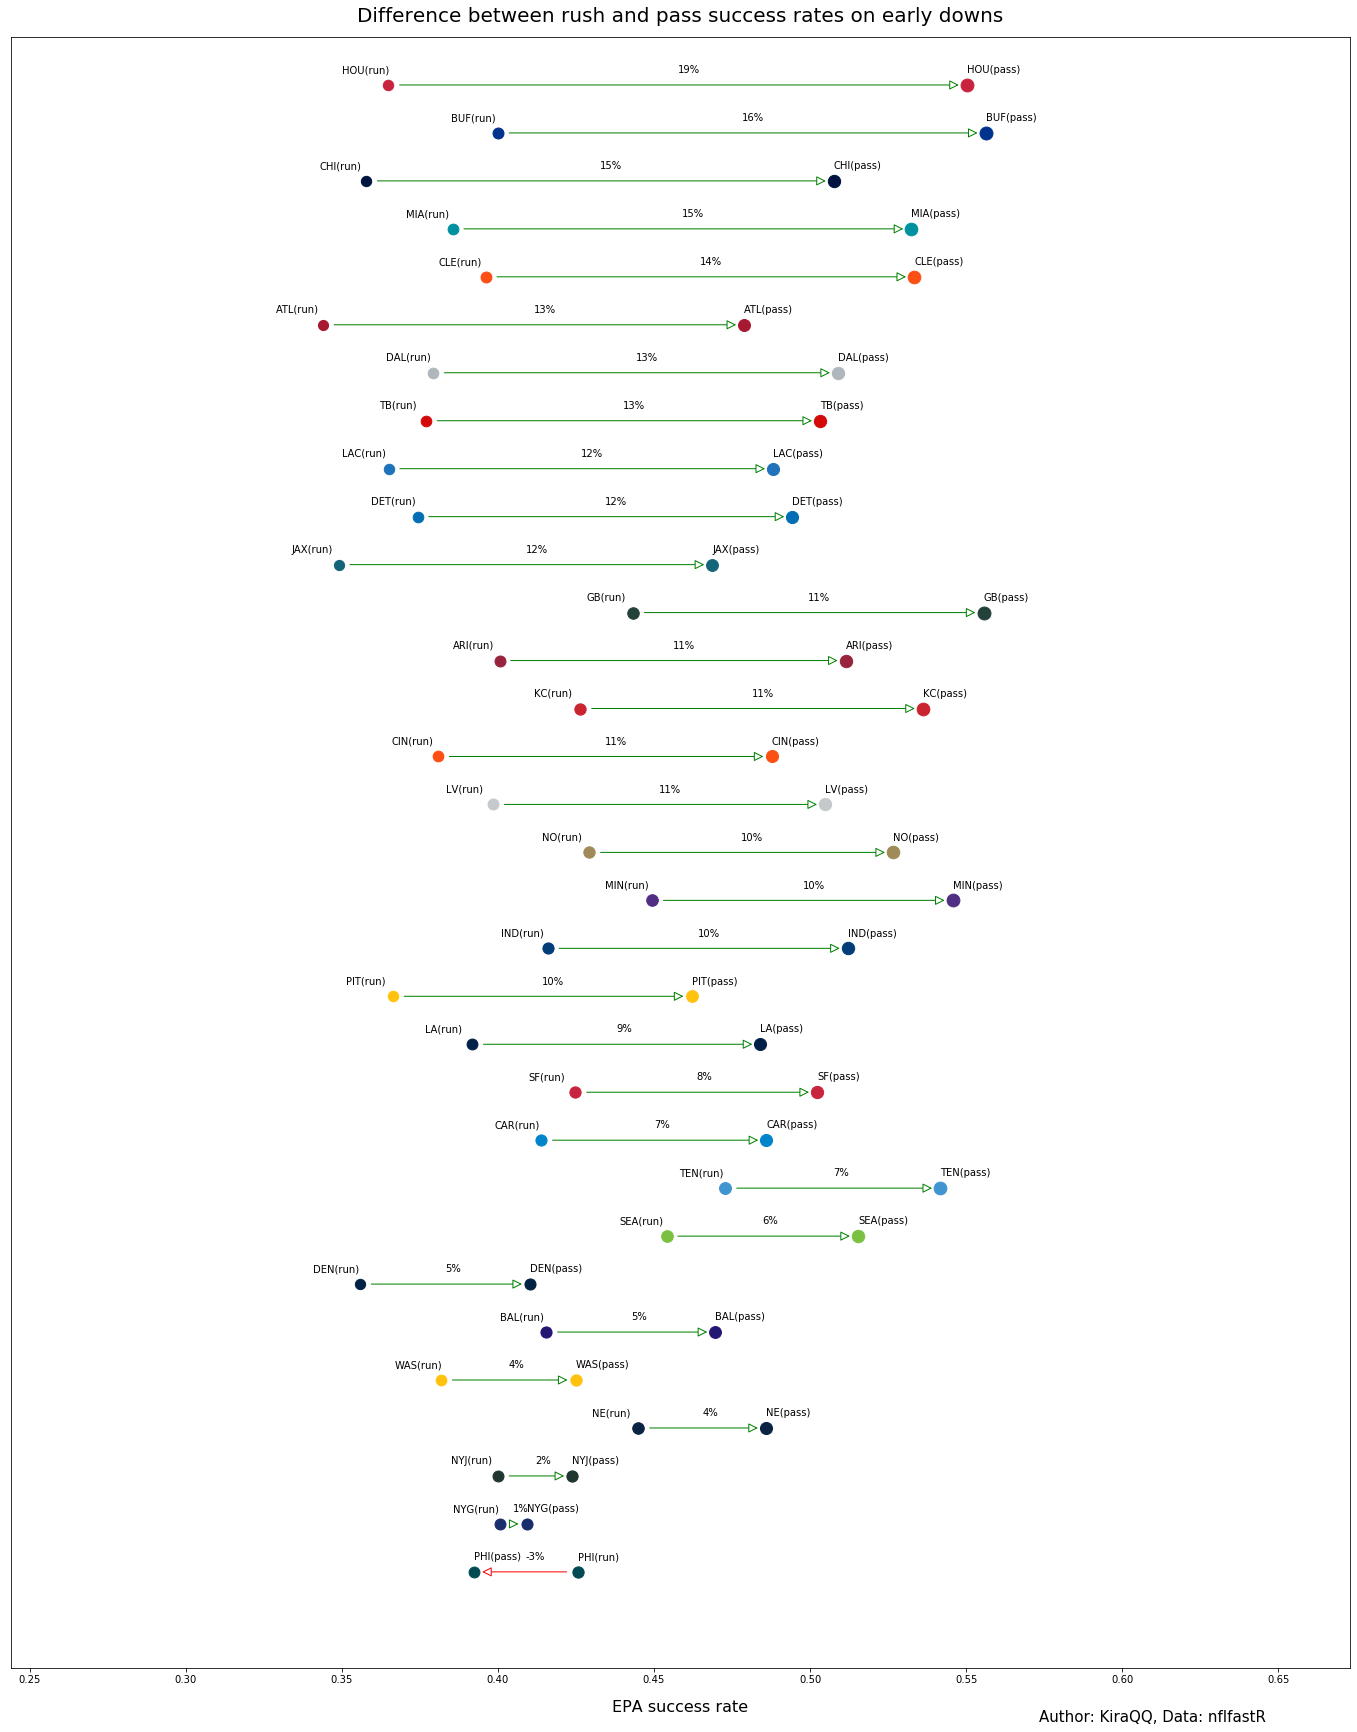

In [13]:
fig, ax = plt.subplots(figsize=(24,30))

ax.set_xlim(SR_data['rush_success_rate'].min() - 0.1, SR_data['rush_success_rate'].max() + 0.2)
ax.set_ylim(-1, 33)

for idx, row in SR_data.iterrows():
    ax.scatter(x = row['rush_success_rate'], y = 32-idx, s = row['rush_success_rate']*300, c = row['color'])
    ax.scatter(x = row['pass_success_rate'], y = 32-idx, s = row['pass_success_rate']*300, c = row['color'])
    if (row['pass_success_rate'] > row['rush_success_rate']):
        plt.text(row['rush_success_rate']-0.015, 32-idx+0.25, row['team'] + '(run)')
        plt.text(row['pass_success_rate'], 32-idx+0.25, row['team'] + '(pass)')
        percentage = str(int(round(row['pass_success_rate']-row['rush_success_rate'],2)*100)) + "%"
        plt.text((row['rush_success_rate']+row['pass_success_rate'])/2, 32-idx+0.25, percentage)
        line = ConnectionPatch((row['rush_success_rate']+0.002, 32-idx), (row['pass_success_rate']-0.001, 32-idx), "data", "data",
        arrowstyle="-|>", shrinkA=5, shrinkB=5,
        mutation_scale=20, fc="w", color='green')
    else:
        plt.text(row['rush_success_rate'], 32-idx+0.25, row['team'] + '(run)')
        plt.text(row['pass_success_rate'], 32-idx+0.25, row['team'] + '(pass)')
        percentage = str(int(round(row['pass_success_rate']-row['rush_success_rate'],2)*100)) + "%"
        plt.text((row['rush_success_rate']+row['pass_success_rate'])/2, 32-idx+0.25, percentage)
        line = ConnectionPatch((row['rush_success_rate']-0.002, 32-idx), (row['pass_success_rate']+0.001, 32-idx), "data", "data",
        arrowstyle="-|>", shrinkA=5, shrinkB=5,
        mutation_scale=20, fc="w", color='red')
    ax.add_artist(line)
    
#Add title, labels, and cite the data source
ax.get_yaxis().set_visible(False)
ax.set_title('Difference between rush and pass success rates on early downs',fontsize=20,pad=15)
ax.set_xlabel('EPA success rate',fontsize=16,labelpad=15)
plt.figtext(.72,.1,'Author: KiraQQ, Data: nflfastR',fontsize=15);


In [14]:
df_late = df[
    (df.down > 2) & (df.down < 5)
].copy()

late_data = (
    df_late.groupby(['posteam']).agg({'success': 'mean', 'wpa': 'count'})
).reset_index()

late_data.sort_values('success', ascending=False, inplace=True)
late_data['success'] = late_data['success']*100
late_avg = late_data['success'].mean()
late_data['color'] = late_data['posteam'].map(COLORS)
late_data['path'] = late_data['posteam'].map(logos)
late_data.reset_index(inplace=True)

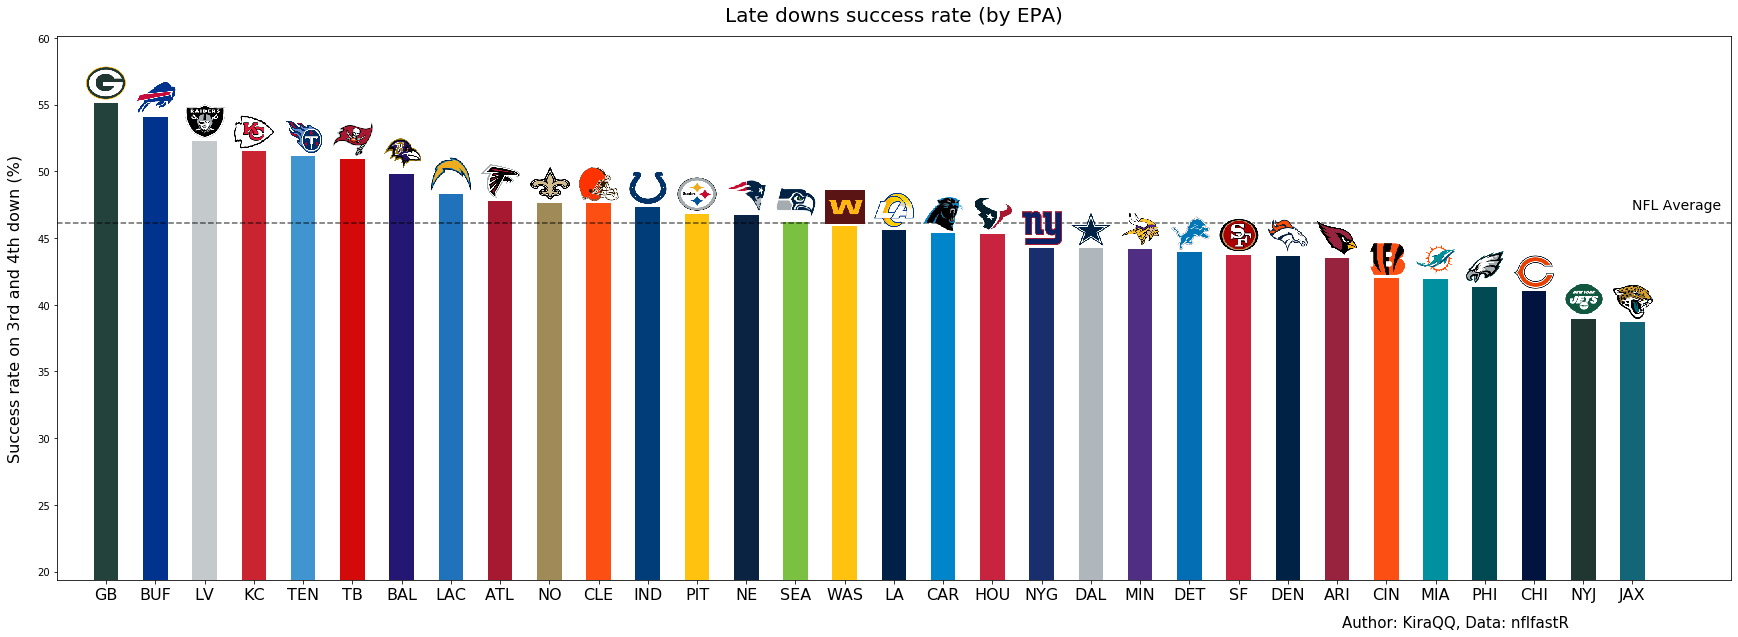

In [15]:
fig, ax = plt.subplots(figsize=(30,10))

ax.bar(np.arange(0,32), late_data['success'], color=late_data.color, width=.5)
ax.set_ylim(late_data['success'].min()/2, late_data['success'].max() + 5)
ax.set_xlim(-1, 33)

for idx, row in late_data.iterrows():
    logo_src = str(row['path'])
    res = requests.get(logo_src)
    img = plt.imread(BytesIO(res.content))
    ax.imshow(img, extent=[idx-0.4, idx+0.4, row['success']+0.2, row['success']+2.7], aspect='auto', zorder=1000)
    
#Add title, labels, and cite the data source
ax.set_title('Late downs success rate (by EPA)',fontsize=20,pad=15)
ax.set_ylabel('Success rate on 3rd and 4th down (%)',fontsize=16,labelpad=15)
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(late_data.posteam,fontsize=16)

#Add league average line and label
ax.axhline(y=late_avg,linestyle='--',color='black', alpha=.6)
plt.text(31, late_avg + 1, 'NFL Average',fontsize=14)

plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [16]:
df_spec = data[
        (data.special_teams_play == 1) &
        (data['epa'].isna()==False) & 
        (data['week'] < 18)
        ].copy()

In [17]:
st_pos = (
    df_spec.groupby(['posteam']).agg({'epa': 'mean', 'wpa': 'count'})
    ).reset_index(level='posteam')
st_pos.columns = ['team', 'pos_epa', 'pos_plays']

st_def = (
    df_spec.groupby(['defteam']).agg({'epa': 'mean', 'wpa': 'count'})
    ).reset_index(level='defteam')
st_def.columns = ['team', 'def_epa', 'def_plays']

st_data = pd.merge(st_pos, st_def, left_on='team', right_on='team')
st_data['epa'] = st_data['pos_epa']*st_data['pos_plays']/(st_data['pos_plays']+st_data['def_plays']) + st_data['def_epa']*st_data['def_plays']/(st_data['pos_plays']+st_data['def_plays'])

st_data.sort_values('epa', ascending=False, inplace=True)
st_avg = st_data['epa'].mean()
st_data['color'] = st_data['team'].map(COLORS)
st_data['path'] = st_data['team'].map(logos)
st_data.reset_index(inplace=True)

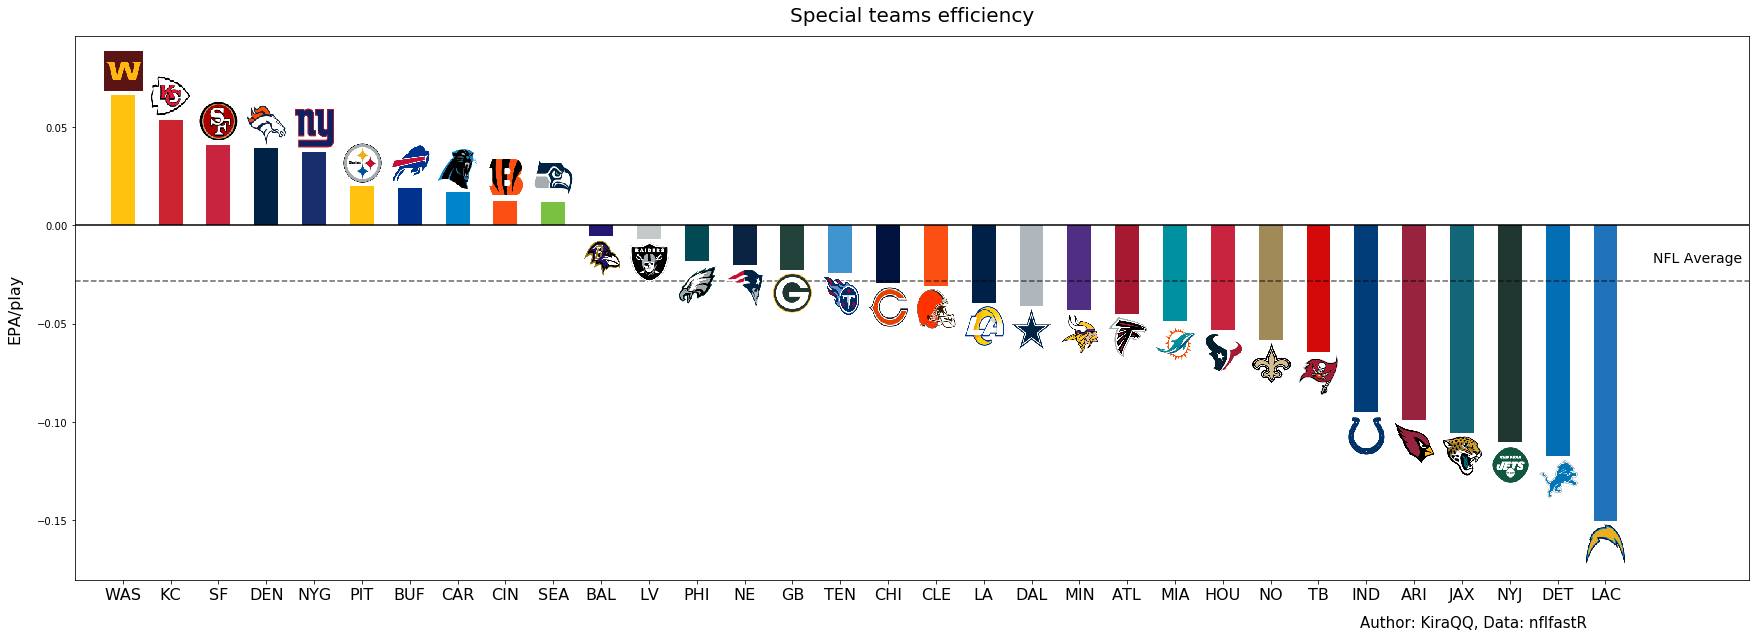

In [18]:
fig, ax = plt.subplots(figsize=(30,10))

ax.bar(np.arange(0,32), st_data['epa'], color=st_data.color, width=.5)
ax.set_ylim(st_data['epa'].min()-0.03, st_data['epa'].max() + 0.03)
ax.set_xlim(-1, 34)

for idx, row in st_data.iterrows():
    logo_src = str(row['path'])
    res = requests.get(logo_src)
    img = plt.imread(BytesIO(res.content))
    if row['epa'] > 0:
        ax.imshow(img, extent=[idx-0.4, idx+0.4, row['epa']+0.002, row['epa']+0.022], aspect='auto', zorder=1000)
    else:
        ax.imshow(img, extent=[idx-0.4, idx+0.4, row['epa']-0.022, row['epa']-0.002], aspect='auto', zorder=1000)
    
    
#Add title, labels, and cite the data source
ax.set_title('Special teams efficiency',fontsize=20,pad=15)
ax.set_ylabel('EPA/play',fontsize=16,labelpad=15)
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(st_data.team,fontsize=16)

#Add league average line and label
ax.axhline(y=0,linestyle='-',color='black', alpha=1)
ax.axhline(y=st_avg,linestyle='--',color='black', alpha=.6)
plt.text(32, st_avg + 0.01, 'NFL Average',fontsize=14)

plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

# Player stats:

In [19]:
qb_data = (
    df.groupby(['passer','posteam']).agg({'epa': 'mean','cpoe': 'mean', 'yards_gained': 'sum', 'pass_touchdown': 'sum', 'wpa': 'count'})
    ).reset_index(level='posteam')

qb_data = qb_data.loc[qb_data.wpa > 160]
qb_data.sort_values('epa', ascending=False, inplace=True)
qb_data.columns = ['posteam', 'EPA_play', 'CPOE', 'yards', 'pTD', 'Plays']

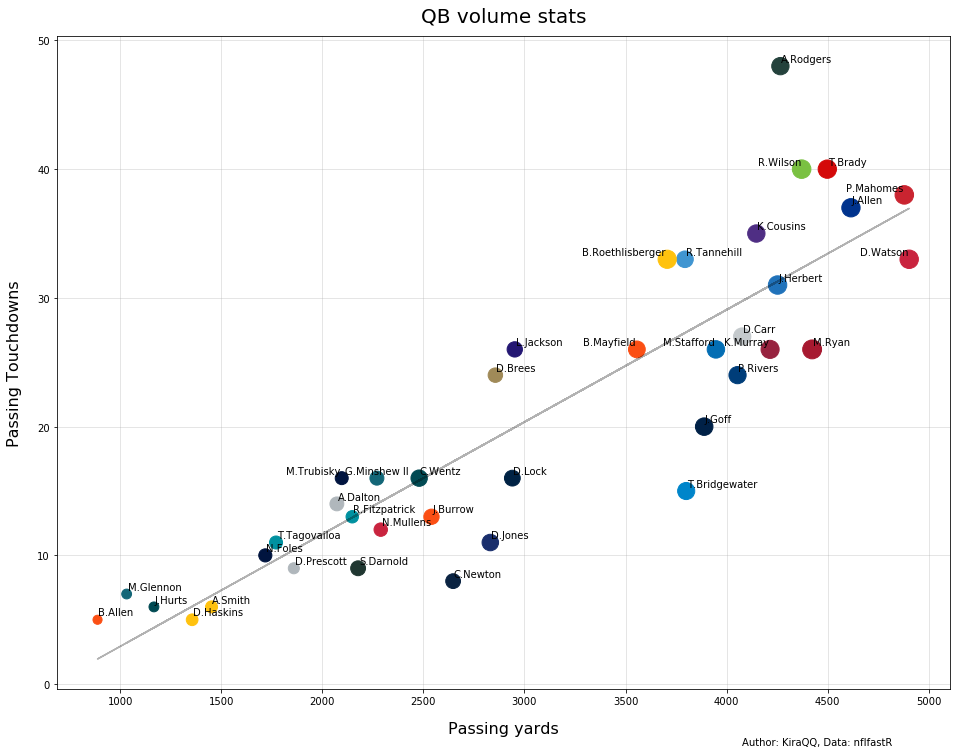

In [20]:
fig, ax = plt.subplots(figsize=(16,12))
qb_data['color'] = qb_data['posteam'].map(COLORS)
ax.scatter(x = qb_data.yards, y = qb_data.pTD, s = qb_data.Plays/2, c = qb_data.color)

texts = [plt.text(x0+0.1,y0+0.1,name,ha='right',va='bottom') for x0,y0,name in zip(
    qb_data.yards, qb_data.pTD, qb_data.index)]

adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(qb_data.yards, qb_data.pTD, 1)
plt.plot(qb_data.yards, m*qb_data.yards + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('QB volume stats',fontsize=20,pad=15)
ax.set_xlabel('Passing yards',fontsize=16,labelpad=15)
ax.set_ylabel('Passing Touchdowns',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=10);

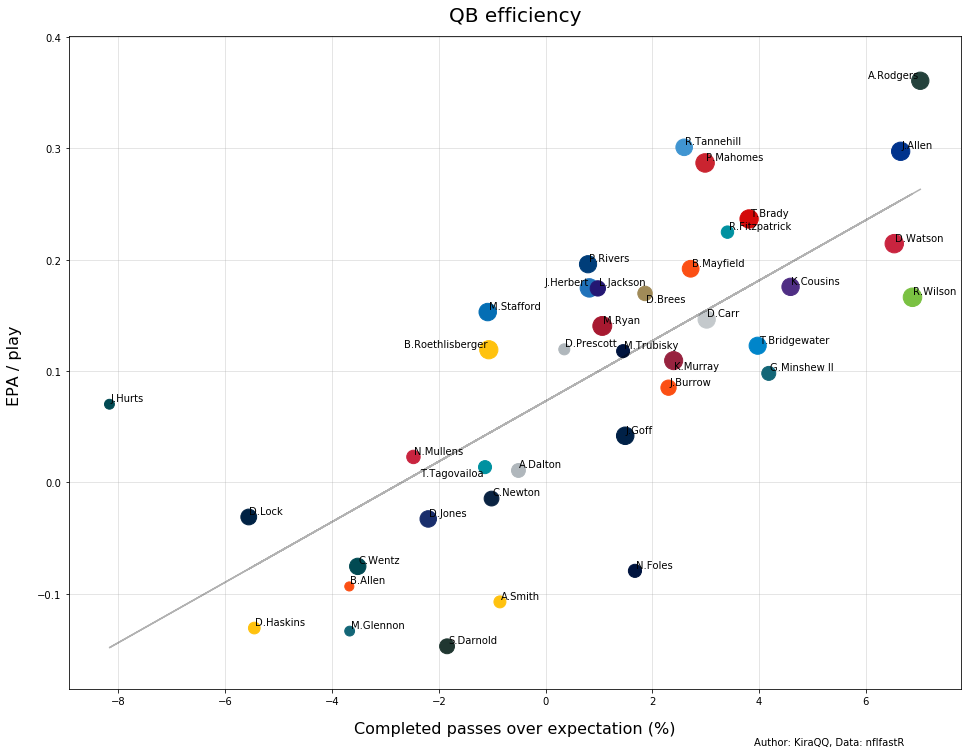

In [21]:
fig, ax = plt.subplots(figsize=(16,12))
qb_data['color'] = qb_data['posteam'].map(COLORS)
ax.scatter(x = qb_data.CPOE, y = qb_data.EPA_play, s = qb_data.Plays/2, c = qb_data.color)

texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
    qb_data.CPOE, qb_data.EPA_play, qb_data.index)]

adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(qb_data.CPOE, qb_data.EPA_play, 1)
plt.plot(qb_data.CPOE, m*qb_data.CPOE + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('QB efficiency',fontsize=20,pad=15)
ax.set_xlabel('Completed passes over expectation (%)',fontsize=16,labelpad=15)
ax.set_ylabel('EPA / play ',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=10);

In [22]:
wr_data = (
    df.groupby(['receiver','posteam']).agg({'epa': 'mean','cpoe': 'mean', 'yards_gained': 'sum', 'pass_touchdown': 'sum', 'wpa': 'count'})
    ).reset_index(level='posteam')

wr_data = wr_data.loc[wr_data.wpa > 80]
wr_data.sort_values('yards_gained', ascending=False, inplace=True)
wr_data.columns = ['posteam', 'EPA_play', 'CPOE', 'yards', 'pTD', 'Plays']

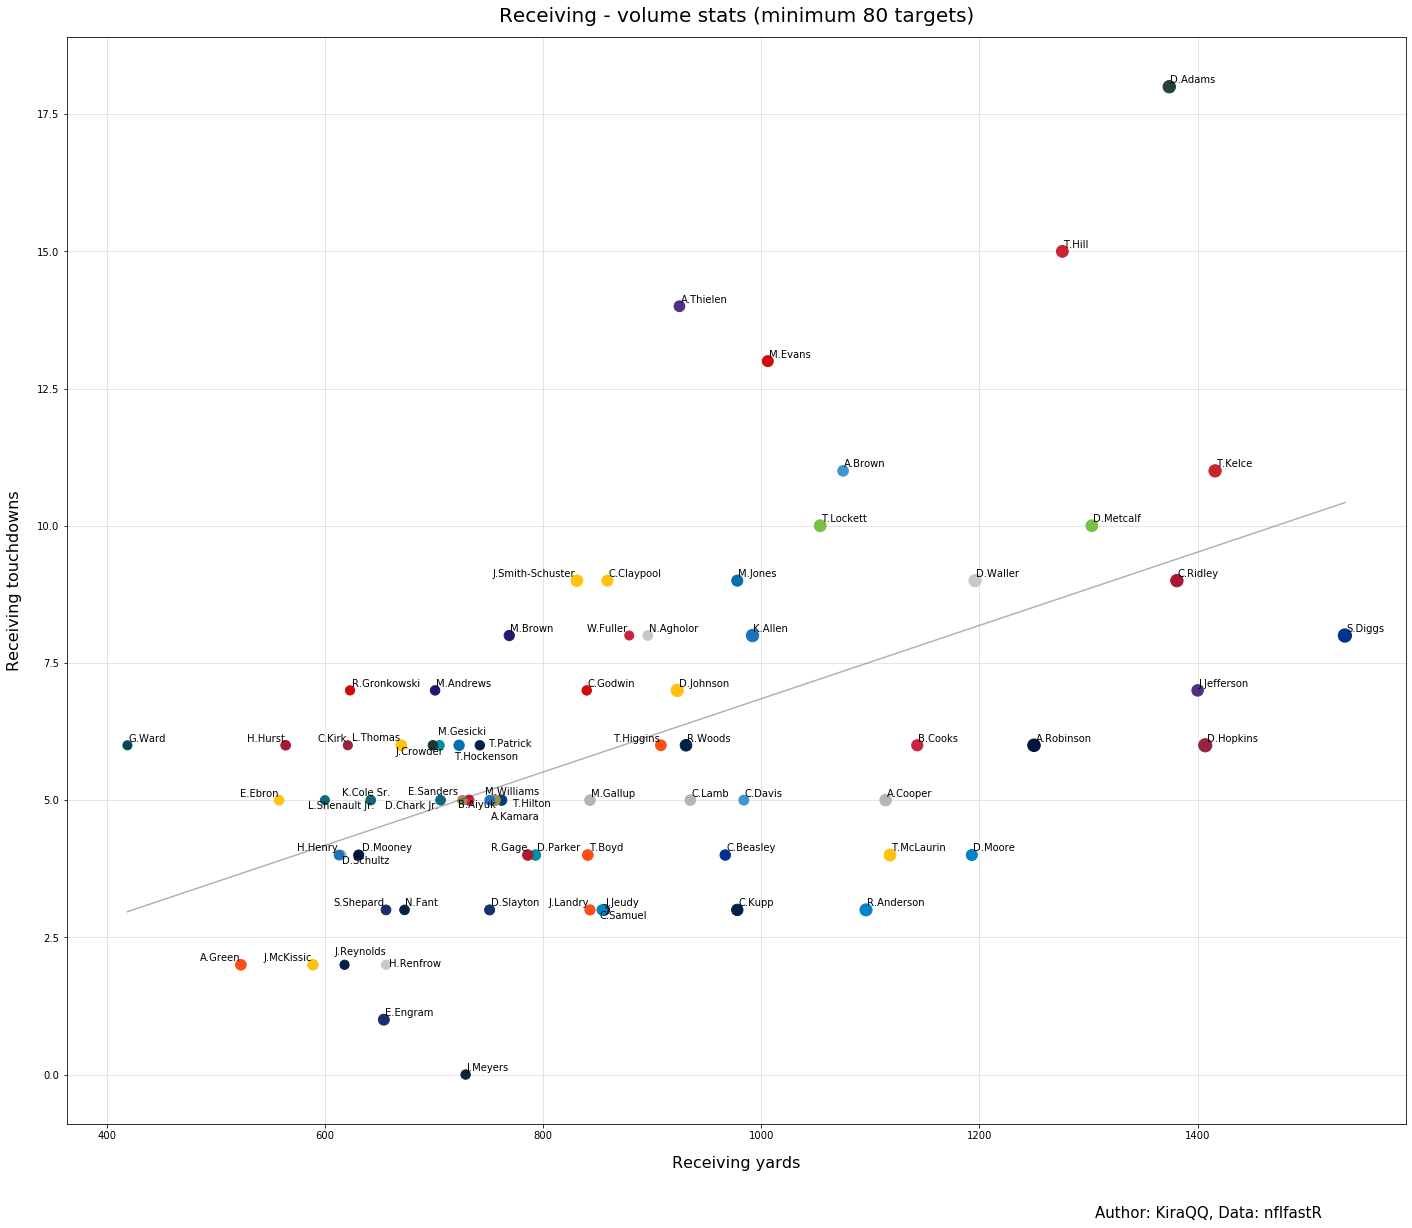

In [23]:
fig, ax = plt.subplots(figsize=(24,20))
wr_data['color'] = wr_data['posteam'].map(COLORS)
ax.scatter(x = wr_data.yards, y = wr_data.pTD, s = wr_data.Plays, c = wr_data.color)

texts = [plt.text(x0+0.1,y0+0.015,name,ha='right',va='bottom') for x0,y0,name in zip(
    wr_data.yards, wr_data.pTD, wr_data.index)]

adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(wr_data.yards, wr_data.pTD, 1)
plt.plot(wr_data.yards, m*wr_data.yards + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('Receiving - volume stats (minimum 80 targets)',fontsize=20,pad=15)
ax.set_xlabel('Receiving yards',fontsize=16,labelpad=15)
ax.set_ylabel('Receiving touchdowns',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

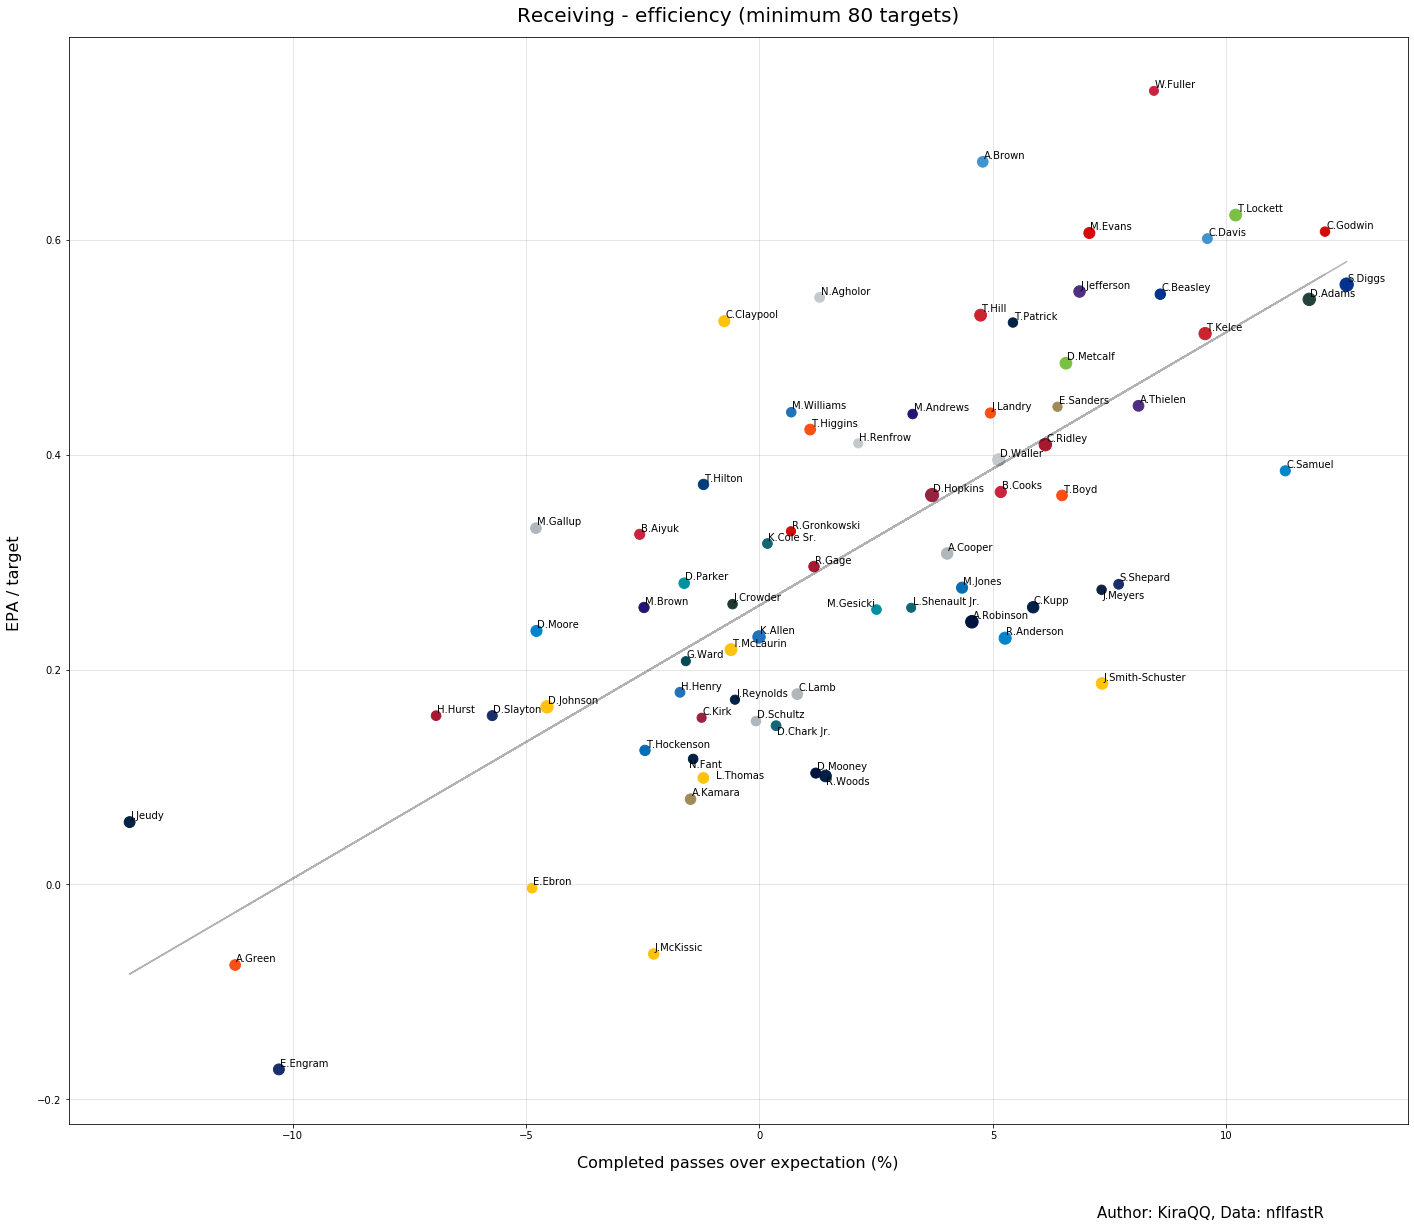

In [24]:
fig, ax = plt.subplots(figsize=(24,20))
wr_data['color'] = wr_data['posteam'].map(COLORS)
ax.scatter(x = wr_data.CPOE, y = wr_data.EPA_play, s = wr_data.Plays, c = wr_data.color)

texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
    wr_data.CPOE, wr_data.EPA_play, wr_data.index)]


adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(wr_data.CPOE, wr_data.EPA_play, 1)
plt.plot(wr_data.CPOE, m*wr_data.CPOE + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('Receiving - efficiency (minimum 80 targets)',fontsize=20,pad=15)
ax.set_xlabel('Completed passes over expectation (%)',fontsize=16,labelpad=15)
ax.set_ylabel('EPA / target ',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [25]:
wr_df = df[
          df.complete_pass==1
          ]

wr_data_comp = (
    wr_df.groupby(['receiver','posteam']).agg({'air_yards': 'mean', 'yards_after_catch': 'mean','wpa': 'count'})
    ).reset_index(level='posteam')

wr_data_comp = wr_data_comp.loc[wr_data_comp.wpa > 48]
wr_data_comp.sort_values('air_yards', ascending=False, inplace=True)
wr_data_comp.columns = ['posteam', 'air', 'yac', 'Plays']

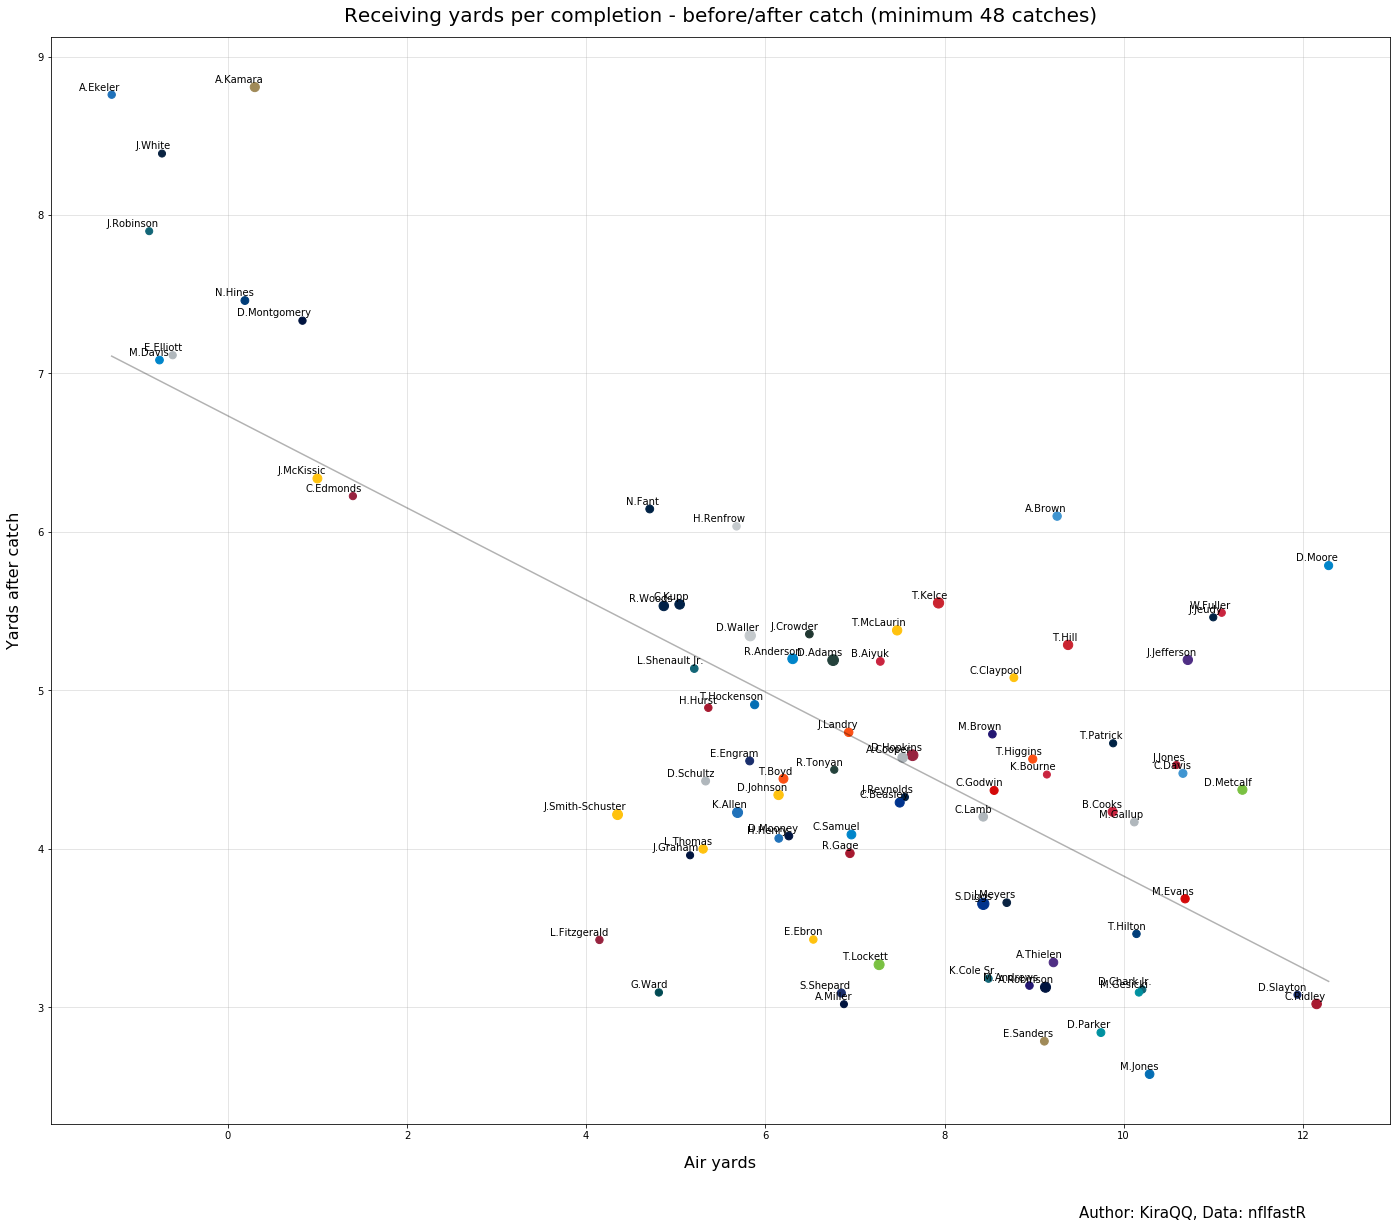

In [26]:
fig, ax = plt.subplots(figsize=(24,20))
wr_data_comp['color'] = wr_data_comp['posteam'].map(COLORS)
ax.scatter(x = wr_data_comp.air, y = wr_data_comp.yac, s = wr_data_comp.Plays, c = wr_data_comp.color)

texts = [plt.text(x0+0.1,y0+0.015,name,ha='right',va='bottom') for x0,y0,name in zip(
    wr_data_comp.air, wr_data_comp.yac, wr_data_comp.index)]


#adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(wr_data_comp.air, wr_data_comp.yac, 1)
plt.plot(wr_data_comp.air, m*wr_data_comp.air + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('Receiving yards per completion - before/after catch (minimum 48 catches)',fontsize=20,pad=15)
ax.set_xlabel('Air yards', fontsize=16,labelpad=15)
ax.set_ylabel('Yards after catch',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

In [27]:
rb_data = (
    df.groupby(['rusher','posteam']).agg({'epa': 'mean','success': 'mean', 'yards_gained': 'sum', 'rush_touchdown': 'sum', 'wpa': 'count'})
    ).reset_index(level='posteam')

rb_data = rb_data.loc[rb_data.wpa > 100]
rb_data.sort_values('epa', ascending=False, inplace=True)
rb_data.columns = ['posteam', 'EPA_play', 'success_rate', 'yards', 'rTD', 'Plays']

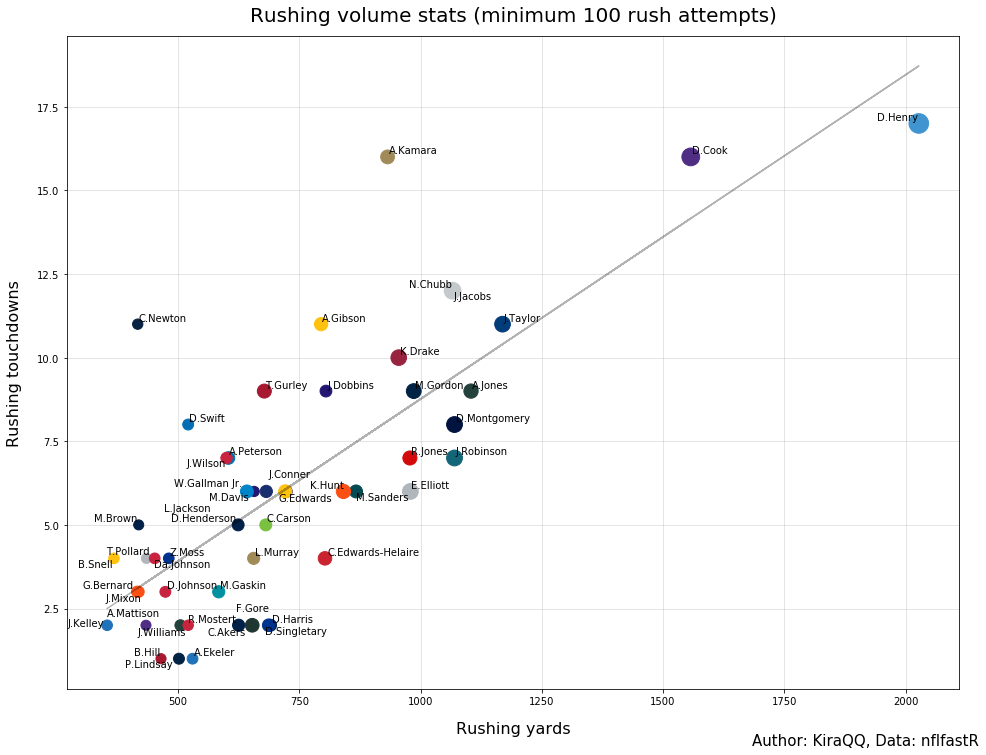

In [28]:
fig, ax = plt.subplots(figsize=(16,12))
rb_data['color'] = rb_data['posteam'].map(COLORS)
ax.scatter(x = rb_data.yards, y = rb_data.rTD, s = rb_data.Plays, c = rb_data.color)

texts = [plt.text(x0+0.1,y0+0.015,name,ha='right',va='bottom') for x0,y0,name in zip(
    rb_data.yards, rb_data.rTD, rb_data.index)]


adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(rb_data.yards, rb_data.rTD, 1)
plt.plot(rb_data.yards, m*rb_data.yards + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('Rushing volume stats (minimum 100 rush attempts)',fontsize=20,pad=15)
ax.set_xlabel('Rushing yards', fontsize=16,labelpad=15)
ax.set_ylabel('Rushing touchdowns',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

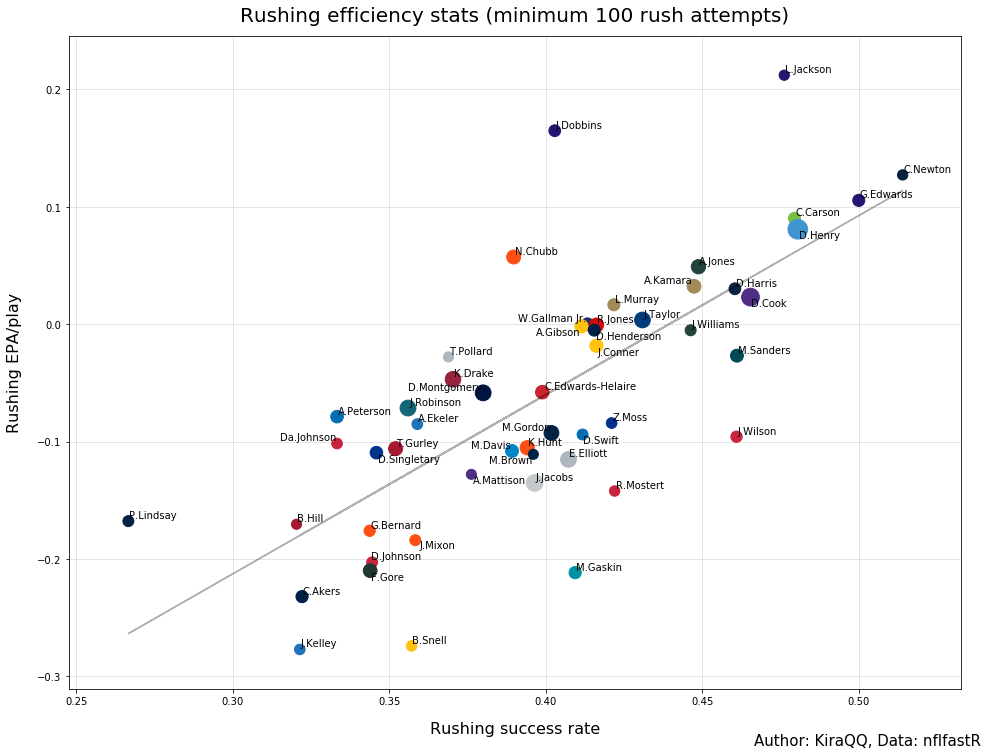

In [29]:
fig, ax = plt.subplots(figsize=(16,12))
rb_data['color'] = rb_data['posteam'].map(COLORS)
ax.scatter(x = rb_data.success_rate, y = rb_data.EPA_play, s = rb_data.Plays, c = rb_data.color)

texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
    rb_data.success_rate, rb_data.EPA_play, rb_data.index)]


adjust_text(texts)

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

#Add trend line
m, b = np.polyfit(rb_data.success_rate, rb_data.EPA_play, 1)
plt.plot(rb_data.success_rate, m*rb_data.success_rate + b, 'k', alpha=.3,linestyle='-')

#Add title, labels, and cite the data source
ax.set_title('Rushing efficiency stats (minimum 100 rush attempts)',fontsize=20,pad=15)
ax.set_xlabel('Rushing success rate', fontsize=16,labelpad=15)
ax.set_ylabel('Rushing EPA/play',fontsize=16,labelpad=15)
plt.figtext(.72,.06,'Author: KiraQQ, Data: nflfastR',fontsize=15);

# Games

## Most notable offensive games

In [30]:
off_games = (
    df.groupby(['posteam', 'defteam', 'week']).agg({'epa': 'mean'})
)

off_games.index.names = ['Good offensive team', 'Opponent', 'Week']
off_games.columns = ['EPA/play']
off_games.sort_values('EPA/play', ascending=False, inplace=True)
off_games.head(10)

,,,EPA/play
Good offensive team,Opponent,Week,
GB,CHI,17,0.472096
TEN,DET,15,0.464409
CLE,CIN,7,0.457842
TB,ATL,17,0.430206
LA,PHI,2,0.411938
BUF,NE,16,0.407350
NO,MIN,16,0.394978
TB,DET,16,0.393232
BAL,CLE,14,0.388656


## Most notable defensive games

In [31]:
def_games = (
    df.groupby(['defteam', 'posteam', 'week']).agg({'epa': 'mean'})
)

def_games.index.names = ['Good defensive team', 'Opponent', 'Week']
def_games.columns = ['EPA/play']
def_games.sort_values('EPA/play', ascending=True, inplace=True)
def_games.head(10)

,,,EPA/play
Good defensive team,Opponent,Week,
NO,DEN,12,-0.716557
ATL,LV,12,-0.675903
TB,DET,16,-0.552626
LA,NE,14,-0.542057
BAL,CIN,17,-0.531082
LA,MIA,8,-0.509583
PIT,CLE,6,-0.479663
NO,TB,9,-0.479063
WAS,DAL,12,-0.465719


## Most notable special teams games

In [32]:
SP_games = (
    df_spec.groupby(['home_team', 'away_team', 'week']).agg({'epa': 'mean', 'wpa': 'count'})
).reset_index()

SP_games['epa_abs'] = abs(SP_games['epa'])
SP_games.sort_values('epa_abs', ascending=False, inplace=True)
SP_games = SP_games.head(10)

SP_games.loc[SP_games['epa'] >= 0, 'good_team'] = SP_games['home_team']
SP_games.loc[SP_games['epa'] < 0, 'bad_team'] = SP_games['home_team']
SP_games.loc[SP_games['epa'] >= 0, 'bad_team'] = SP_games['away_team']
SP_games.loc[SP_games['epa'] < 0, 'good_team'] = SP_games['away_team']

SP_games = SP_games[['good_team', 'bad_team', 'week', 'epa_abs']]
SP_games.columns = ['Good special team', 'Bad special team', 'week', 'EPA/play']

SP_games.set_index(['Good special team', 'Bad special team', 'week'])

,,,EPA/play
Good special team,Bad special team,week,
NE,LAC,13,0.743085
JAX,LAC,7,0.697669
DET,MIN,9,0.582925
NO,SF,10,0.505665
MIN,TB,14,0.498241
TB,DET,16,0.471683
SF,ARI,16,0.469165
WAS,CAR,16,0.428169
HOU,CLE,10,0.415223
